In [3]:
import cv2
from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import random
import os

### DLT Implementation

In [4]:
# function to display the coordinates of the points clicked on the image we will be printing the image co-ordinates on the screen and then use them
def click_event(event, x, y, flags, params):

	# checking for left mouse clicks
	if event == cv2.EVENT_LBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print('[{},{}],'.format(x,y))

	# checking for right mouse clicks	
	if event==cv2.EVENT_RBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print('[{},{}],'.format(x,y))



def world_to_image_coord(img_path):
	# reading the image
	img = cv2.imread(img_path)

	# displaying the image
	cv2.imshow('image', img)

	# setting mouse handler for the image and calling the click_event() function
	cv2.setMouseCallback('image', click_event)

	# wait for a key to be pressed to exit
	cv2.waitKey(0)

	# close the window
	cv2.destroyAllWindows()

In [47]:
world_to_image_coord('../data/measurements.jpg')

[484,216],
[397,211],
[487,139],
[474,246],
[493,55],
[465,280],


In [31]:
# using the below world co-ordinates, we will find the corresponding image co-ordinates.
world_coord = [
    [0,0,0],
    [36,0,0],
    [0,36,0],
    [0,0,36],
    [0,72,0],
    [0,0,72]
]

# by running the cell above, we got the image co-ordinates as
image_coord = [
[484,216],
[397,211],
[487,139],
[474,246],
[493,55],
[465,280]
]

In [26]:
# we obtained the world and image co-ordinates, now obtain the matrix P
def dlt(world_coord, image_coord):
    
    # converting co-ordinates to float
    world_coord = np.array(world_coord).astype('float32')
    image_coord = np.array(image_coord).astype('float32')

    # G matrix
    G = np.zeros((12,12))
    for i in range(6):
        X,Y,Z = world_coord[i,:]
        u,v = image_coord[i,:]
        G[2*i,:] = [0,0,0,0,-X,-Y,-Z,-1,u*X,u*Y,u*Z,u]
        G[2*i+1,:] = [-X,-Y,-Z,-1,0,0,0,0,v*X,v*Y,v*Z,v]

    # calculate the SVD for G and return the minimum eigen vectors as p
    u,s,vh = np.linalg.svd(G)
    ind = np.argmin(s) # Generally 11
    Pt = vh[ind,:]
    P = Pt.reshape(3,4)

    # predicted image co-ordinates Xc = P . Xw
    A = P.dot(np.concatenate((world_coord.T,np.ones((1,6))),axis=0))
    # image co-ordinates will be x/w, y/w
    A = A[[1,0],:]/A[2,:]

    image_pred = np.zeros((6,2))

    for i in range(6):
        image_pred[i,0] = A[0,i]
        image_pred[i,1] = A[1,i]

    mse = np.mean((image_coord-image_pred)**2)

    # finding intrinsic and extrinsic parameters
    M = P[:,0:3]
    p4 = P[:,3]

    # QR factorization of matrix M
    R,K = np.linalg.qr(M)
    # we are dividing with (2,2) element, so that it becomes 1 (Remember form of K matrix)
    K = K/K[2,2]
    K_inv = np.linalg.inv(K)
    # As T = (K inverse) . p4
    T = K_inv.dot(p4)

    return image_pred, K, R, T, P, M, mse

In [33]:
image_pred, K, R, T, P, M, mse = dlt(world_coord, image_coord)
print('MSE: ',mse)
print('\nThe P matrix is: ',P)
print('\nThe M matrix is: ',M)

MSE:  1.5090418573335516

The P matrix is:  [[ 4.69316684e-01 -5.28778540e-12  1.33171252e-12  4.95980137e-10]
 [ 8.83027125e-01 -1.17085112e-12 -1.77161074e-12  1.11253875e-09]
 [ 2.22424968e-03 -2.80331314e-15 -2.63677968e-15  2.30325699e-12]]

The M matrix is:  [[ 4.69316684e-01 -5.28778540e-12  1.33171252e-12]
 [ 8.83027125e-01 -1.17085112e-12 -1.77161074e-12]
 [ 2.22424968e-03 -2.80331314e-15 -2.63677968e-15]]


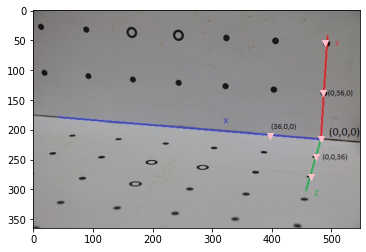

The World Co-ordinates are:  [[0, 0, 0], [36, 0, 0], [0, 36, 0], [0, 0, 36], [0, 72, 0], [0, 0, 72]]


In [34]:
data = image.imread('../data/measurements.jpg')

for i in range(6):
    plt.plot(image_pred[i][0],image_pred[i][1],marker='v', color='pink')

plt.imshow(data)
plt.show()

# printing world co-ordinates to get assured
print('The World Co-ordinates are: ',world_coord)

In [35]:
print('The Intrinsic Parameters of the Camera are :')
print('The K matrix : ',K)

print('\nThe Extrinsic Parameters of the Camera are :')
print('The Rotation matrix : ',R)
print('The Translation matrix : ',T)

The Intrinsic Parameters of the Camera are :
The K matrix :  [[-5.27198901e+14  1.85339170e+03  4.95246064e+02]
 [ 0.00000000e+00 -2.17193886e+03  1.05829322e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

The Extrinsic Parameters of the Camera are :
The Rotation matrix :  [[-4.69316684e-01  8.83029926e-01  3.12793340e-05]
 [-8.83027125e-01 -4.69315105e-01 -2.53550812e-03]
 [-2.22424968e-03 -1.21757676e-03  9.99996785e-01]]
The Translation matrix :  [3.36752015e-24 6.10045954e-13 2.30325699e-12]


### RANSAC Implementation

In [29]:
# taking 30 world points randomly of the image
world_coord = [
    [0,72,0],
    [0,36,0],
    [0,0,0],
    [0,0,36],
    [0,0,72],
    [0,0,108],
    [36,72,0],
    [36,36,0],
    [36,0,0],
    [36,0,36],
    [36,0,72],
    [36,0,108],
    [72,72,0],
    [72,36,0],
    [72,0,0],
    [72,0,36],
    [72,0,72],
    [72,0,108],
    [108,72,0],
    [108,36,0],
    [108,0,0],
    [108,0,36],
    [108,0,72],
    [108,0,108],
    [144,72,0],
    [144,36,0],
    [144,0,0],
    [144,0,36],
    [144,0,72],
    [144,0,108],
]

In [ ]:
world_to_image_coord('../data/measurements.jpg')

In [30]:
image_coord = [
[493, 56],
[488,   138],
[483,   216],
[474,   246],
[466,   279],
[454 ,  317],
[407  , 51],
[405   ,135],
[398  , 210],
[388  , 240],
[374 ,  271],
[358 ,  310],
[324  , 45],
[326  , 129],
[319 ,  203],
[304 ,  232],
[283 ,  264],
[264 ,  299],
[245 ,  41],
[245 ,  123],
[241 ,  195],
[222  , 224],
[200 ,  256],
[172 ,  292],
[166  , 37],
[169  , 116],
[163  , 190],
[144  , 217],
[116  , 248],
[85   ,284]
]

In [3]:
# we have 30 points. choose random 6 points among them, till some number of iterations 
# and minimize the mse
def ransac(world_coord, image_coord):
    n_iter = 150
    best = {}
    min_mse = 1e10
    sz = len(world_coord)
    for i in range(n_iter):
        # taking 6 radnom indices in range 0 - size of world coord list
        indices = random.sample(range(0,sz),6)

        test_world = []
        test_image = []
        for ind in indices:
            test_world.append(world_coord[ind])
            test_image.append(image_coord[ind])

        image_pred, K, R, T, P, M, mse = dlt(test_world, test_image)

        if mse < min_mse:
            min_mse = mse
            best['K'] = K
            best['R'] = R
            best['T'] = T
            best['P'] = P
            best['M'] = M
            best['mse'] = mse

    return best

In [32]:
best = ransac(world_coord,image_coord)
print('The best K matrix is: ',best['K'])
print('\nThe best R matrix is: ',best['R'])
print('\nThe best T matrix is: ',best['T'])
print('\nThe best P matrix is: ',best['P'])
print('\nThe best M matrix is: ',best['M'])
print('\nThe best MSE is: ',best['mse'])

The best K matrix is:  [[-879.00733261 -120.90178003 -541.67581985]
 [  -0.          918.35057665 -123.00276902]
 [  -0.           -0.            1.        ]]

The best R matrix is:  [[-5.95331754e-02  9.98226309e-01 -1.93879467e-04]
 [-9.98226324e-01 -5.95331569e-02  9.98342815e-05]
 [ 8.81149496e-05  1.99479039e-04  9.99999976e-01]]

The best T matrix is:  [-0.00179213  0.00124551  0.00187692]

The best P matrix is:  [[-2.40633563e-04 -4.24853039e-03  4.16323853e-04  4.08026989e-01]
 [-4.03483864e-03 -3.03562055e-04 -2.52008537e-03  9.12945480e-01]
 [ 3.56161319e-07 -7.93396926e-07 -4.26607040e-06  1.87692176e-03]]

The best M matrix is:  [[-2.40633563e-04 -4.24853039e-03  4.16323853e-04]
 [-4.03483864e-03 -3.03562055e-04 -2.52008537e-03]
 [ 3.56161319e-07 -7.93396926e-07 -4.26607040e-06]]

The best MSE is:  0.0005363813174173324


Observations: The MSE in RANSAC is way too much less than that in DLT, which means choosing random points can help calibrate camera better.

### Radial Distortion

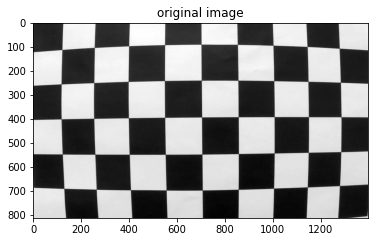

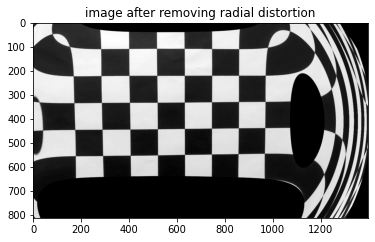

In [49]:
radial_real = np.zeros((4*8,3), np.float32)
radial_real[:,:2] = np.mgrid[0:8,0:4].T.reshape(-1,2)

def correctRadialDistortion(real_coords, a, b, filePath):
    img = cv2.cvtColor(cv2.imread(filePath), cv2.COLOR_BGR2GRAY)
    plt.imshow(img, cmap='gray')
    plt.title('original image')
    plt.show()
    ret, corners = cv2.findChessboardCorners(img, (a, b))
    # print([real_coords], [corners])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([real_coords], [corners], img.shape[::-1], None, None)    
    h, w = img.shape[:2]

    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    plt.imshow(dst, cmap='gray')
    plt.title('image after removing radial distortion')
    plt.show()

correctRadialDistortion(radial_real, 8, 4, '../chess.jpg')

### Creating a Wireframe for the object
Using the World Co-ordinates and the P matrix.

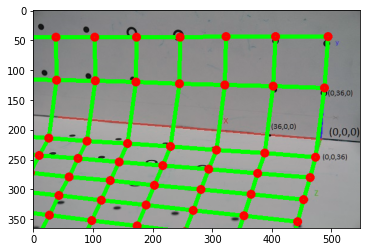

In [159]:
P = best['P']  #choosing the best P matrix to be used
calb_im = cv2.imread('../data/measurements.jpg')

# function which can draw lines between 2 points
def draw_lines(start,end):
    X1,Y1,Z1 = start
    X2,Y2,Z2 = end
    v1,u1,c1 = P.dot([X1,Y1,Z1,1])
    v2,u2,c2 = P.dot([X2,Y2,Z2,1])
    cv2.line(calb_im, (int(u1/c1), int(v1/c1)), (int(u2/c2), int(v2/c2)), (0,255,0), 6)
    cv2.circle(calb_im,(int(u1/c1), int(v1/c1)),4,(255,0,0),6)
    cv2.circle(calb_im,(int(u2/c2), int(v2/c2)),4,(255,0,0),6)

# joining x-y plane
x1 = 0 
y1 = 72
z1 = 0
for i in range(7):
    x2 = 36*(i+1)
    y2 = 72
    z2 = 0
    draw_lines((x1,y1,z1),(x2,y2,z2))
    draw_lines((x1,y1/2,z1),(x2,y2/2,z2))
    draw_lines((x1,y1/2,z1),(x1,y2,z2))
    x1=x2
    y1=y2
    z1=z2

# joining x-z plane
for j in range(5):
    x1 = 0 
    y1 = 0
    z1 = 36*(j+1)
    for i in range(7):
        x2 = 36*(i+1)
        y2 = 0
        z2 = z1
        draw_lines((x1,y1,z1),(x2,y2,z2))
        draw_lines((x1,y1,z1),(x1,y1,z1+36))
        x1=x2
        y1=y2
        z1=z2
    
# joining out of plane points
y1 = 36
z1 = 0
for i in range(7):
    x1 = 36*i
    x2 = 36*i
    y2 = 0
    z2 = 36
    draw_lines((x1,y1,z1),(x2,y2,z2))

plt.imshow(calb_im)

Observation: The overlay doesn't fit perfectly with all points, because of radial distortion and even could be because the original image points and predicted image points(calculated using world points) are not mapping with good precision.

### Zhang's Calibration

In [160]:
zhang_imgs = []
total_files = 0
for i,filename in enumerate(os.listdir('../data/')):
    total_files += 1

for i,filename in enumerate(os.listdir('../data/')):
    # skipping the first and last file
    if i==0 or i==total_files-1:
        continue
    else:
    #  Read Image
        img = cv2.imread(os.path.join('../data/',filename))
        zhang_imgs.append(img)

In [168]:
# initialization
points_3d = []
points_2d = []

# Define 3rd world points if all corners are detected
x,y=np.meshgrid(range(8),range(6))
world_coord=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)
print(world_coord.shape)
# 8*6 corners, so that's why 48

(48, 3)


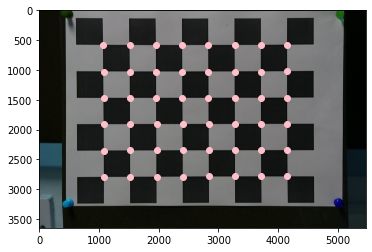

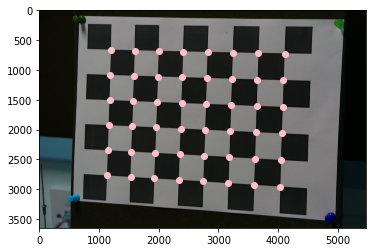

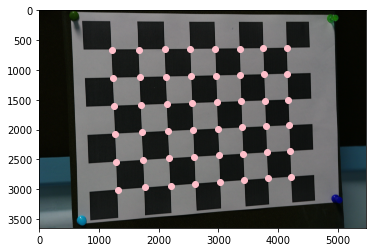

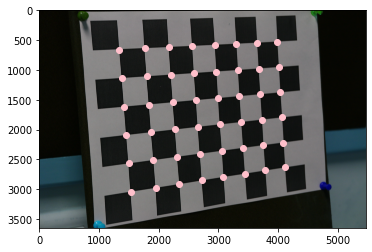

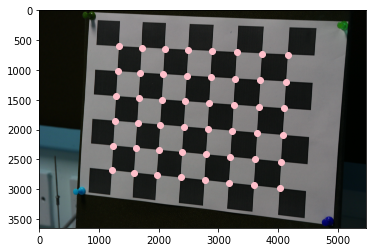

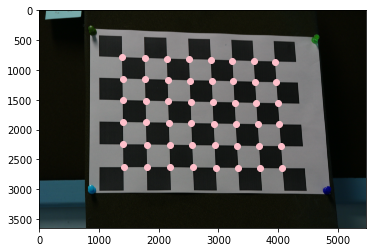

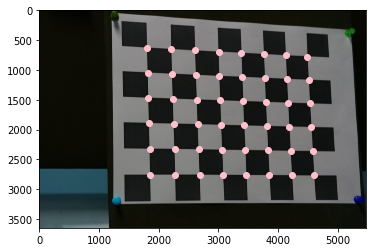

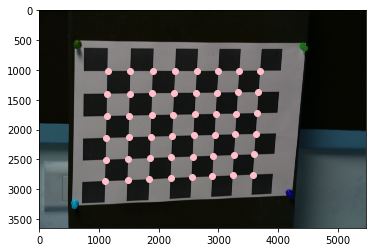

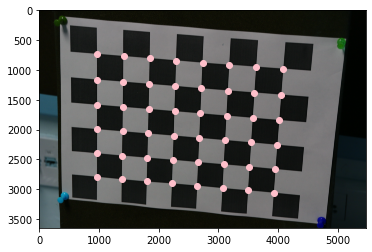

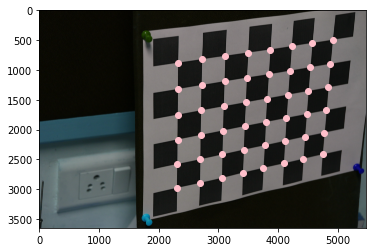

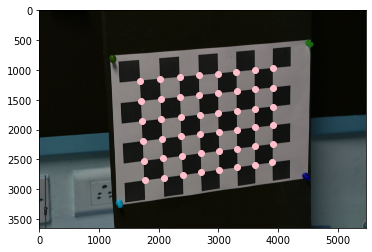

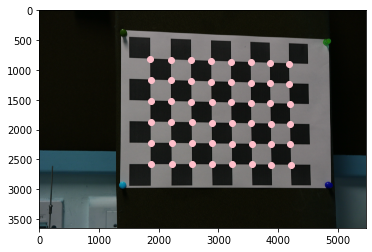

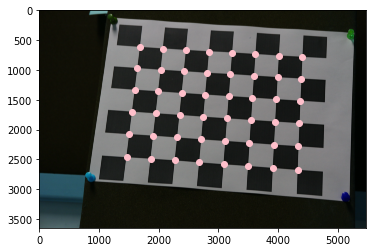

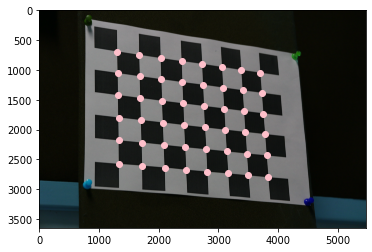

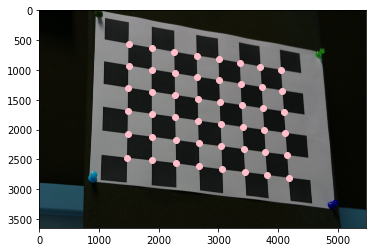

In [169]:
# looping over all images
zhang_imgs_vis = []
for img in zhang_imgs:
    ret, corners = cv2.findChessboardCorners(img, (8,6))
    
    if ret: #add points only if checkerboard was correctly detected:
        points_2d.append(corners) #append current 2D points  
        points_3d.append(world_coord) #3D points are always the same
    
    img_vis=img.copy()        
    for corner in corners:
        plt.plot(corner[0,0],corner[0,1],marker='o', color='pink')
    zhang_imgs_vis.append(img_vis)
    plt.imshow(img_vis)
    plt.show()

In [170]:
# open-cv built-in calibration module
# Requires all 2d points and their corresponding 3d points and size of the image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points_3d, points_2d, (img.shape[1],img.shape[0]), None, None)

print ("Ret(Error):",ret)
print ("Mtx(Intrinsic Matrix):\n",mtx," ----------------------------------> [",mtx.shape,"]")
print ("Distortion:\n",dist," ----------> [",dist.shape,"]")
print ("All rotation vecs:\n",rvecs," --------------------------------------------------------> [",rvecs[0].shape,"]")
print ("Translation vecs:\n",tvecs," -------------------------------------------------------> [",tvecs[0].shape,"]")

Ret(Error): 2.481084983863812
Mtx(Intrinsic Matrix):
 [[1.36634773e+04 0.00000000e+00 3.33653656e+03]
 [0.00000000e+00 1.36813826e+04 1.49660118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]  ----------------------------------> [ (3, 3) ]
Distortion:
 [[ 9.52132296e-02  1.01092580e+01 -1.52797799e-02  2.87213434e-02
  -1.60589622e+02]]  ----------> [ (1, 5) ]
All rotation vecs:
 (array([[-0.01318085],
       [-0.05189257],
       [-0.00310183]]), array([[-0.00723369],
       [ 0.22652165],
       [ 0.03532859]]), array([[-0.00906861],
       [-0.41619662],
       [-0.03572076]]), array([[ 0.01633962],
       [-0.61839259],
       [-0.07755518]]), array([[0.00456626],
       [0.30778498],
       [0.06543949]]), array([[-0.32566614],
       [-0.22232074],
       [-0.01742858]]), array([[-0.19221712],
       [-0.38502427],
       [-0.00381479]]), array([[ 0.24427921],
       [-0.32262063],
       [ 0.02472159]]), array([[0.31114498],
       [0.0663294 ],
       [0.07053942]]), arr

Observation: The Zhang's method is better than DLT, because points/corners are mapped with better accuracy or precision

### Wireframe overlay using the internal parameters estimated from Zhang’s method.

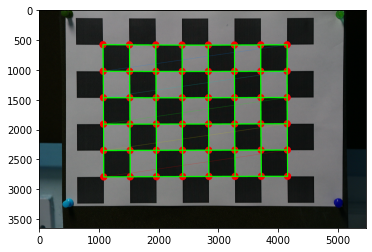

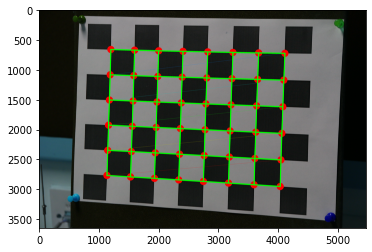

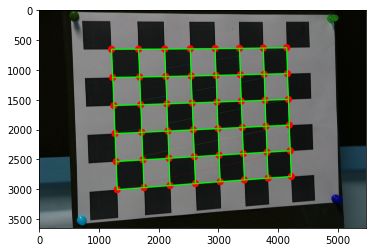

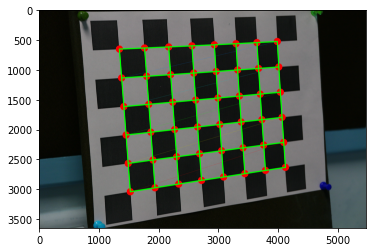

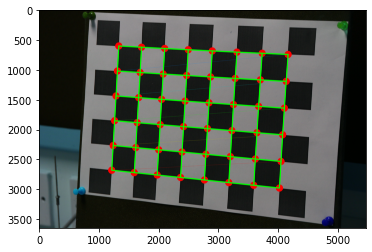

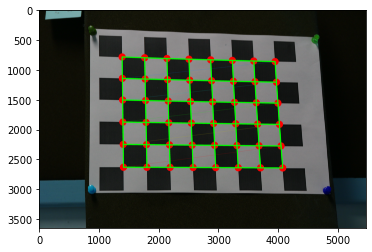

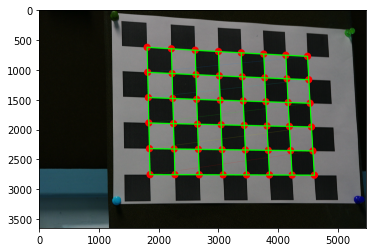

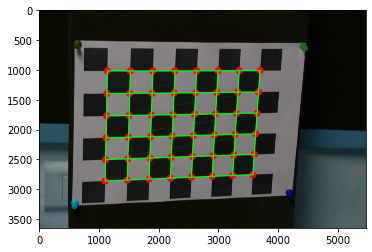

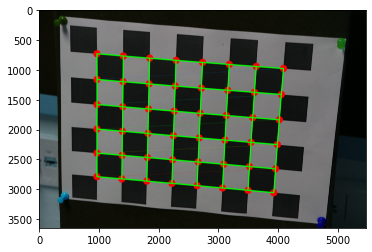

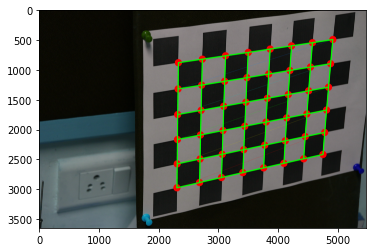

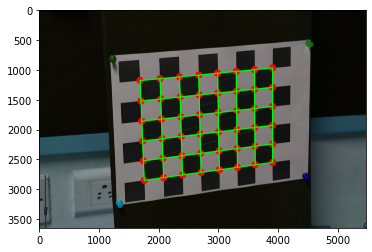

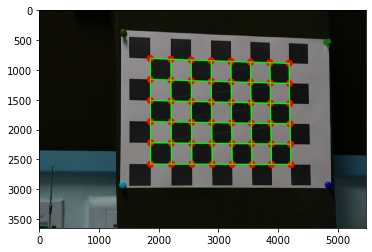

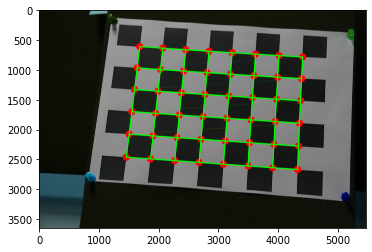

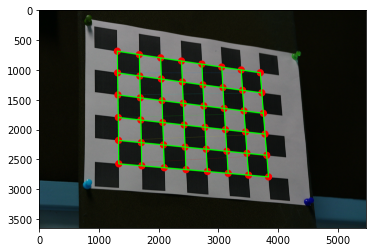

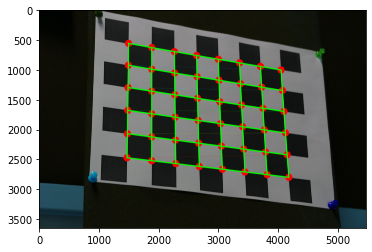

In [230]:
# Project 3d points of all cameras to 2d using rotation matrix and camera matrix
pred2d_list = []
for i in range(len(points_3d)):
    # predicted 2d points
    pred2d, _ = cv2.projectPoints(points_3d[i], rvecs[i], tvecs[i], mtx, dist)

    X = []
    Y = []
    img = zhang_imgs_vis[i].copy()
    c = 0
    matrix = []
    lst = []
    for j in range(len(pred2d)):
        x = int(pred2d[j][0][0])
        y = int(pred2d[j][0][1])
        cv2.circle(img,(x, y),30,(255,0,0),60)
        lst.append((x,y))
        c += 1
        if c == 8:
            matrix.append(lst)
            c = 0
            lst = []
        
    # horizontal lines
    for i in range(6):
        for j in range(7):
            x1 = matrix[i][j][0]
            y1 = matrix[i][j][1]
            x2 = matrix[i][j+1][0]
            y2 = matrix[i][j+1][1]
            cv2.line(img, (x1,y1), (x2,y2), (0,255,0), 20)

    # vertical lines
    for j in range(8):
        for i in range(5):
            x1 = matrix[i][j][0]
            y1 = matrix[i][j][1]
            x2 = matrix[i+1][j][0]
            y2 = matrix[i+1][j][1]
            cv2.line(img, (x1,y1), (x2,y2), (0,255,0), 20)

        
    plt.imshow(img)
    plt.show()

Observation: The wireframe fits better here as compared to that formed for RANSAC.

### Image of the World Origin
The Image of the World Origin is p4 column of P matrix only.

483 215


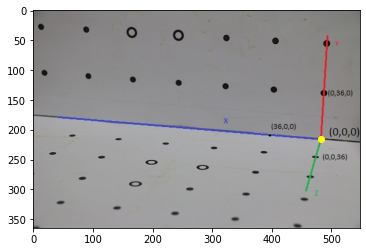

In [43]:
# We take the P matrix calculated from DLT only
# 4th column of the matrix P
col = P[:,3]

y = int(col[0]/col[2])
x = int(col[1]/col[2])

print(x,y)
data = image.imread('../data/measurements.jpg')

plt.plot(x,y,marker='o', color='yellow')
plt.imshow(data)
plt.show()

Observation: So u can see clearly that the p4 is the image of (0,0,0) only viz. world origin, and this result bear out in our observation too.

### Using my object as rubik's cube and applying all the camera calibration techniques
The data for same is available in 'mydata' folder

Take x-axis as the intersection of White and Green Planes

Take y-axis as the intersection of White and Red Planes

Take z-axis as the intersection of Red and Green Planes

### DLT Implementation on Rubik's Cube Image

In [33]:
# Applying DLT
# taking 6 points
world_coord = [
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,-1],
    [2,0,0],
    [0,2,0]
]

In [4]:
world_to_image_coord('../mydata/cube.jpeg')

[317,272],
[416,219],
[205,214],
[314,398],
[505,180],
[104,165],


In [34]:
image_coord = [
[317,272],
[416,219],
[205,214],
[314,398],
[505,180],
[104,165]
]

In [35]:
image_pred, K, R, T, P, M, mse = dlt(world_coord, image_coord)
print('MSE: ',mse)
print('\nThe P matrix is: ',P)
print('\nThe M matrix is: ',M)
print('The Intrinsic Parameters of the Camera are :')
print('The K matrix : ',K)

print('\nThe Extrinsic Parameters of the Camera are :')
print('The Rotation matrix : ',R)
print('The Translation matrix : ',T)

MSE:  27.592171476965873

The P matrix is:  [[ 5.83554023e-14  1.55003559e-13  7.85083167e-01 -6.54019212e-13]
 [-3.84822382e-13  2.54210281e-13  6.19387222e-01 -7.38428416e-13]
 [-3.42821604e-16  5.55111512e-17  1.97257077e-03 -2.32879298e-15]]

The M matrix is:  [[ 5.83554023e-14  1.55003559e-13  7.85083167e-01]
 [-3.84822382e-13  2.54210281e-13  6.19387222e-01]
 [-3.42821604e-16  5.55111512e-17  1.97257077e-03]]
The Intrinsic Parameters of the Camera are :
The K matrix :  [[-1.77147660e-10  1.03814610e-10  2.25145741e+02]
 [ 0.00000000e+00 -8.70964441e-11 -3.95542930e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

The Extrinsic Parameters of the Camera are :
The Rotation matrix :  [[-1.49928339e-01 -9.88696472e-01  8.83241291e-04]
 [ 9.88696474e-01 -1.49929015e-01 -7.56919257e-04]
 [ 8.80786895e-04  7.59773903e-04  9.99999323e-01]]
The Translation matrix :  [ 1.18986678e-02  1.90543487e-02 -2.32879298e-15]


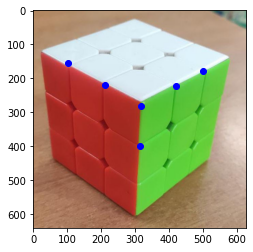

The World Co-ordinates are:  [[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, -1], [2, 0, 0], [0, 2, 0]]


In [36]:
data = image.imread('../mydata/cube.jpg')

for i in range(6):
    plt.plot(image_pred[i][0],image_pred[i][1],marker='o', color='blue')

plt.imshow(data)
plt.show()

# printing world co-ordinates to get assured
print('The World Co-ordinates are: ',world_coord)

### RANSAC Implementation of Rubik's cube Image

In [8]:
world_coord = [
    [0,3,-3],
    [0,3,-2],
    [0,3,-1],
    [0,3,0],
    [1,3,0],
    [2,3,0],
    [3,3,0],
    
    [0,2,-3],
    [0,2,-2],
    [0,2,-1],
    [0,2,0],
    [1,2,0],
    [2,2,0],
    [3,2,0],

    [0,1,-3],
    [0,1,-2],
    [0,1,-1],
    [0,1,0],
    [1,1,0],
    [2,1,0],
    [3,1,0],

    [0,0,-3],
    [0,0,-2],
    [0,0,-1],
    [0,0,0],
    [1,0,0],
    [2,0,0],
    [3,0,0],

    [1,0,-3],
    [1,0,-2],
    [1,0,-1],
    [2,0,-1],
    [3,0,-1],

    [2,0,-3],
    [2,0,-2],
    [3,0,-2],

    [3,0,-3]
]

In [9]:
world_to_image_coord('../mydata/cube.jpg')

[59,432],
[50,345],
[36,239],
[27,124],
[131,87],
[223,55],
[300,25],
[125,481],
[126,393],
[114,284],
[107,166],
[210,123],
[303,91],
[378,60],
[209,541],
[214,455],
[211,341],
[208,212],
[307,171],
[400,135],
[468,99],
[301,602],
[306,513],
[311,399],
[320,272],
[416,223],
[504,180],
[575,143],
[384,538],
[394,454],
[404,346],
[487,293],
[554,254],
[457,485],
[470,399],
[533,355],
[519,433],


In [13]:
image_coord = [
[59,432],
[50,345],
[36,239],
[27,124],
[131,87],
[223,55],
[300,25],
[125,481],
[126,393],
[114,284],
[107,166],
[210,123],
[303,91],
[378,60],
[209,541],
[214,455],
[211,341],
[208,212],
[307,171],
[400,135],
[468,99],
[301,602],
[306,513],
[311,399],
[320,272],
[416,223],
[504,180],
[575,143],
[384,538],
[394,454],
[404,346],
[487,293],
[554,254],
[457,485],
[470,399],
[533,355],
[519,433],
]

In [14]:
print(len(world_coord),len(image_coord))

37 37


In [23]:
best = ransac(world_coord,image_coord)
print('The best K matrix is: ',best['K'])
print('\nThe best R matrix is: ',best['R'])
print('\nThe best T matrix is: ',best['T'])
print('\nThe best P matrix is: ',best['P'])
print('\nThe best M matrix is: ',best['M'])
print('\nThe best MSE is: ',best['mse'])

The best K matrix is:  [[-529.97222047  325.99266939  -29.24532639]
 [   0.         -256.3452833  -519.20722543]
 [   0.            0.            1.        ]]

The best R matrix is:  [[-1.51796681e-01 -9.88410498e-01  1.56717441e-03]
 [ 9.88411465e-01 -1.51797631e-01 -5.05560239e-04]
 [ 7.37594409e-04  1.47227078e-03  9.99998644e-01]]

The best T matrix is:  [ 0.00537276  0.00669562 -0.00207095]

The best P matrix is:  [[ 4.47663405e-02  1.13457089e-01  2.88042325e-01 -6.04128612e-01]
 [-2.91492304e-01  2.00954054e-01  2.77716750e-02 -6.41137884e-01]
 [-2.17523877e-04 -7.62127693e-05  1.19090754e-04 -2.07094922e-03]]

The best M matrix is:  [[ 4.47663405e-02  1.13457089e-01  2.88042325e-01]
 [-2.91492304e-01  2.00954054e-01  2.77716750e-02]
 [-2.17523877e-04 -7.62127693e-05  1.19090754e-04]]

The best MSE is:  0.0003686512493302024


### Zhang's Implementation on checkerboard

(48, 3)


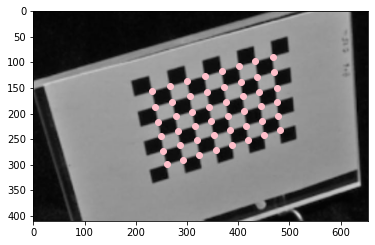

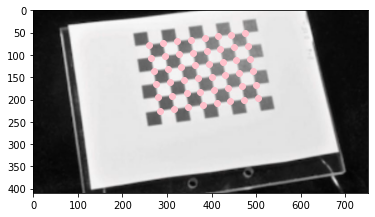

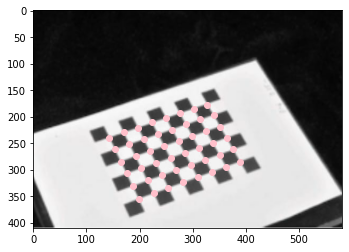

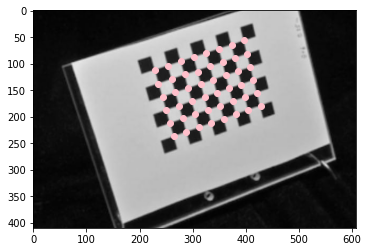

In [27]:
zhang_imgs = []
total_files = 0
for i,filename in enumerate(os.listdir('../mydata/')):
    total_files += 1

for i,filename in enumerate(os.listdir('../mydata/')):
    # skipping the first and last file
    if i==total_files-1:
        continue
    else:
    #  Read Image
        img = cv2.imread(os.path.join('../mydata/',filename))
        zhang_imgs.append(img)

# initialization
points_3d = []
points_2d = []

# Define 3rd world points if all corners are detected
x,y=np.meshgrid(range(8),range(6))
world_coord=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)
print(world_coord.shape)
# 8*6 corners, so that's why 48


# looping over all images
zhang_imgs_vis = []
for img in zhang_imgs:
    ret, corners = cv2.findChessboardCorners(img, (8,6))
    
    if ret: #add points only if checkerboard was correctly detected:
        points_2d.append(corners) #append current 2D points  
        points_3d.append(world_coord) #3D points are always the same
    
    img_vis=img.copy()        
    for corner in corners:
        plt.plot(corner[0,0],corner[0,1],marker='o', color='pink')
    zhang_imgs_vis.append(img_vis)
    plt.imshow(img_vis)
    plt.show()

In [28]:
# open-cv built-in calibration module
# Requires all 2d points and their corresponding 3d points and size of the image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points_3d, points_2d, (img.shape[1],img.shape[0]), None, None)

print ("Ret(Error):",ret)
print ("Mtx(Intrinsic Matrix):\n",mtx," ----------------------------------> [",mtx.shape,"]")
print ("Distortion:\n",dist," ----------> [",dist.shape,"]")
print ("All rotation vecs:\n",rvecs," --------------------------------------------------------> [",rvecs[0].shape,"]")
print ("Translation vecs:\n",tvecs," -------------------------------------------------------> [",tvecs[0].shape,"]")

Ret(Error): 0.6591144291788358
Mtx(Intrinsic Matrix):
 [[1.69911989e+03 0.00000000e+00 3.25695440e+02]
 [0.00000000e+00 1.72197834e+03 2.71693731e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]  ----------------------------------> [ (3, 3) ]
Distortion:
 [[-8.51513363e-01  8.41822727e+01  1.88175644e-02 -7.90009056e-03
  -2.01459967e+03]]  ----------> [ (1, 5) ]
All rotation vecs:
 (array([[ 0.62218441],
       [-0.25610001],
       [-0.22582089]]), array([[-0.31316753],
       [-0.08525875],
       [-0.14959248]]), array([[-0.58396038],
       [-0.18341114],
       [-0.40571086]]), array([[ 0.24491482],
       [-0.29048376],
       [-0.30437018]]))  --------------------------------------------------------> [ (3, 1) ]
Translation vecs:
 (array([[-2.58672545],
       [-3.14581683],
       [46.74483858]]), array([[-2.06207796],
       [-6.12438381],
       [53.77767588]]), array([[-6.27236669],
       [-1.12601112],
       [58.31264962]]), array([[-3.63510543],
       [-5.95251447]